## Notes
Each trial has different items, each with own value (different items for each trial)

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# directories
data_dir = '../data/'
setsizes = np.array([9, 16, 25, 36])
numsubjects = 49

In [3]:
subject = 2
c = 36
tmp_data = pd.read_csv(data_dir+'subject_files/sub-{}_setsize-{}_desc-gazes.csv'.format(subject, c))
tmp_data.head()

,subject,setsize,trial,item,dur,onset,stimulus,gaze_num,is_returning,returning_gaze_count,is_last,is_first,item_value,choice,is_last_to_choice
0,2,36,1,15,144.0,424.0,nr4.png,1.0,0.0,0.0,0.0,1.0,1.0,6,0.0
1,2,36,1,14,136.0,604.0,nr51.png,2.0,0.0,0.0,0.0,0.0,-2.0,6,0.0
2,2,36,1,8,206.0,782.0,nr44.png,3.0,0.0,0.0,0.0,0.0,2.0,6,0.0
3,2,36,1,16,210.0,1210.0,nr56.png,4.0,0.0,0.0,0.0,0.0,0.0,6,0.0
4,2,36,1,33,246.0,1616.0,nr90.png,5.0,0.0,0.0,0.0,0.0,2.0,6,0.0


In [ ]:
items_df = tmp_data[['trial', 'item', 'item_value', 'stimulus']]
#items_df = items_df.drop_duplicates()
items_df.query('item==21')

In [9]:
tmp_data.head()

,subject,setsize,trial,item,dur,onset,stimulus,gaze_num,is_returning,returning_gaze_count,is_last,is_first,item_value,choice,is_last_to_choice
0,2,36,1,15,144.0,424.0,nr4.png,1.0,0.0,0.0,0.0,1.0,1.0,6,0.0
1,2,36,1,14,136.0,604.0,nr51.png,2.0,0.0,0.0,0.0,0.0,-2.0,6,0.0
2,2,36,1,8,206.0,782.0,nr44.png,3.0,0.0,0.0,0.0,0.0,2.0,6,0.0
3,2,36,1,16,210.0,1210.0,nr56.png,4.0,0.0,0.0,0.0,0.0,0.0,6,0.0
4,2,36,1,33,246.0,1616.0,nr90.png,5.0,0.0,0.0,0.0,0.0,2.0,6,0.0


## Fit gamma to durations

<AxesSubplot: >

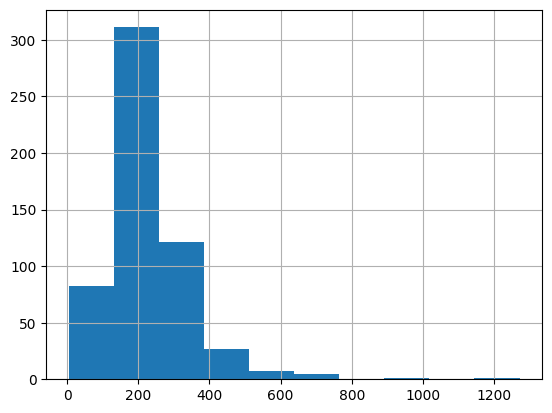

In [6]:
# check duration distro of duration - many short ones
tmp_data.dur.hist()

In [23]:
# fit gamma to durations
from scipy.stats import gamma, lognorm
import seaborn as sns

In [29]:
# Fit a Gamma distribution to the data
fit_alpha, fit_loc, fit_beta = lognorm.fit(tmp_data.dur)

In [27]:
# Generate values for the probability density function (PDF)
x = np.linspace(min(tmp_data.dur), max(tmp_data.dur), 100)
pdf_values = lognorm.pdf(x, fit_alpha, loc=fit_loc, scale=fit_beta)

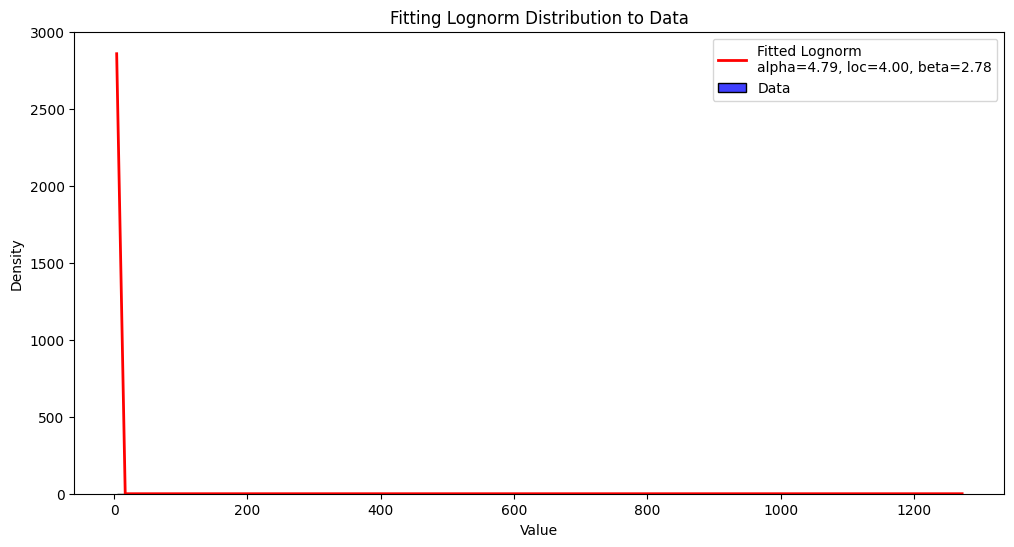

In [32]:
# Plotting
plt.figure(figsize=(12, 6))
sns.histplot(tmp_data.dur, bins=30, kde=False, color='blue', label='Data', stat='density')
plt.plot(x, pdf_values, 'r-', lw=2, label=f'Fitted Lognorm\nalpha={fit_alpha:.2f}, loc={fit_loc:.2f}, beta={fit_beta:.2f}')
plt.title('Fitting Lognorm Distribution to Data')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

In [31]:
# Output the estimated parameters
print(f"Estimated Alpha (Shape): {fit_alpha}")
print(f"Estimated Loc: {fit_loc}")
print(f"Estimated Beta (Scale): {fit_beta}")

Estimated Alpha (Shape): 4.788607214045944
Estimated Loc: 3.999999999678816
Estimated Beta (Scale): 2.778015247807027


## Choices

In [19]:
c = 36
session_nums = []
choices = []
item_value_dict = {}
for subject in range(numsubjects):
    tmp_data = pd.read_csv(data_dir+'subject_files/sub-{}_setsize-{}_desc-gazes.csv'.format(subject, c))
    session_nums.append( len(tmp_data.trial.unique()))
    choices.append(len(tmp_data.choice.unique()))
    items = tmp_data[['item', 'item_value']]

In [20]:
df = pd.DataFrame({"sessions":session_nums, "choices":choices})

In [21]:
df.choices.describe()

count    49.000000
mean     24.551020
std       3.697191
min      13.000000
25%      23.000000
50%      25.000000
75%      27.000000
max      31.000000
Name: choices, dtype: float64

<AxesSubplot:ylabel='Frequency'>

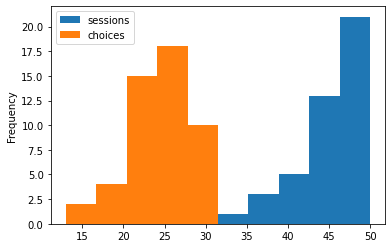

In [22]:
df.plot.hist()

## For each subject, fit lognormal distro to duration times

In [34]:
from scipy.stats import norm, expon, lognorm, weibull_min
from scipy.optimize import minimize

In [33]:
num_subj = 48

In [35]:
# Function to calculate the negative log-likelihood for a given distribution and data
def negative_log_likelihood(params, data, distribution):
    if distribution == 'normal':
        mu, std = params
        log_likelihood = -np.sum(norm.logpdf(data, mu, std))
    elif distribution == 'exponential':
        _, scale = params
        log_likelihood = -np.sum(expon.logpdf(data, scale=scale))
    elif distribution == 'lognormal':
        mu, std = params
        log_likelihood = -np.sum(lognorm.logpdf(data, std, scale=np.exp(mu)))
    elif distribution == 'weibull':
        c, _, scale = params
        log_likelihood = -np.sum(weibull_min.logpdf(data, c, scale=scale))
    else:
        raise ValueError("Invalid distribution")
    
    return log_likelihood

In [41]:
results = []
for i in range(num_subj):
    fname = '../data/subject_files/' + f'sub-{i}_setsize-36_desc-gazes.csv'
    data = pd.read_csv(fname)
    dur_data_new = data['dur']
    params_initial = [np.log(np.mean(dur_data_new)), np.std(np.log(dur_data_new))]

    # Minimize the negative log-likelihood
    distribution = 'lognormal'
    result = minimize(negative_log_likelihood, params_initial, args=(dur_data_new, distribution))
    results.append((i, distribution, result.fun, result.x[0], result.x[1]))

In [42]:
results_df = pd.DataFrame(results, columns=['Subject', 'Distribution', 'Negative Log-Likelihood', 'mu', 'sigma'])

In [44]:
results_df.head()

,Subject,Distribution,Negative Log-Likelihood,mu,sigma
0,0,lognormal,5246.878317,5.290226,0.503992
1,1,lognormal,4312.718892,5.293565,0.447236
2,2,lognormal,3385.928095,5.284860,0.547153
3,3,lognormal,3972.112396,5.186634,0.477904
4,4,lognormal,6640.880646,5.457363,0.502971


In [ ]:
plt.scatter(results_df.mu, results_df.sigma)

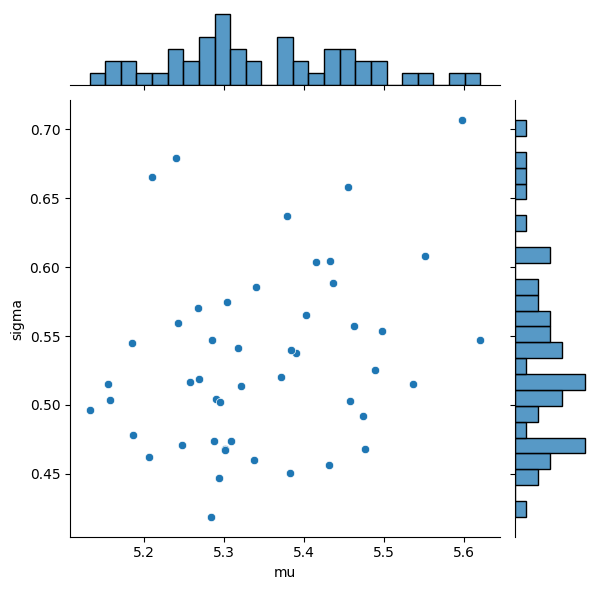

In [48]:
# Create a scatter plot with histograms on each axis using seaborn's `jointplot`
sns.jointplot(x=results_df.mu, y=results_df.sigma, kind='scatter', marginal_kws=dict(bins=25, fill=True))


In [49]:
results_df.to_csv('duration_lognormal_fit.csv')